## 1. Set up the environment

In [1]:
!pip install keract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

from google.colab import files
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [3]:
kaggle_token_file = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!mv /content/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c mds-ufu-dl-test --force

 78% 13.0M/16.7M [00:00<00:00, 58.3MB/s]
100% 16.7M/16.7M [00:00<00:00, 54.6MB/s]


In [7]:
!unzip mds-ufu-dl-test.zip

Archive:  mds-ufu-dl-test.zip
replace fmnist_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: fmnist_test.csv         
  inflating: fmnist_train.csv        
  inflating: sample_submission.csv   


In [8]:
!ls -lah

total 88M
drwxr-xr-x 1 root root 4.0K Jun 12 01:32 .
drwxr-xr-x 1 root root 4.0K Jun 12 01:10 ..
drwxr-xr-x 4 root root 4.0K Jun  8 18:17 .config
-rw-r--r-- 1 root root  22M Apr 24 08:42 fmnist_test.csv
-rw-r--r-- 1 root root  50M Apr 24 08:42 fmnist_train.csv
-rw-r--r-- 1 root root  17M Jun 12 01:32 mds-ufu-dl-test.zip
drwxr-xr-x 1 root root 4.0K Jun  8 18:18 sample_data
-rw-r--r-- 1 root root  68K Apr 24 08:42 sample_submission.csv


## 2. Load datasets

### 2.1 Train dataset

In [17]:
# s1, s2 - slicing indices
def visualize_item(df, index, s1=1, s2=-1):
    pixels = df.iloc[index, s1:s2]
    pixels = pixels.values.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()

In [10]:
train_df = pd.read_csv('/content/fmnist_train.csv')

In [11]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0,2
3,0,0,0,0,1,2,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [27]:
train_df.isna().sum().sum()

424

In [28]:
train_df = train_df.fillna(0)

In [29]:
train_df.isna().sum().sum()

0

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17040 entries, 0 to 17039
Columns: 786 entries, label to Id
dtypes: float64(424), int64(362)
memory usage: 102.2 MB


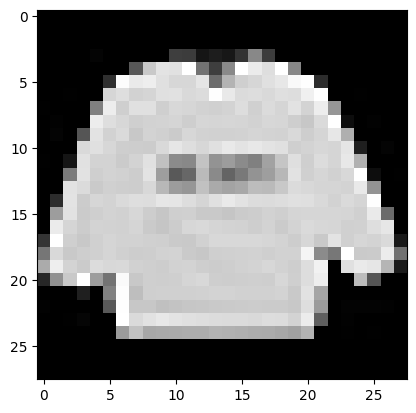

In [30]:
visualize_item(train_df, 0)

### 2.2 Test dataset

In [14]:
test_df = pd.read_csv('/content/fmnist_test.csv')

In [40]:
# just to be safe
test_df.isna().sum().sum()

0

In [15]:
test_df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,0,0,0,0,0,0,0,9,8,0,...,87,56,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,63,53,31,0,0,0,2
3,0,0,0,0,0,0,0,0,0,161,...,126,140,0,133,224,222,56,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


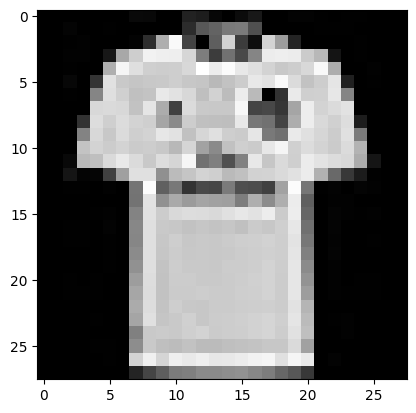

In [16]:
visualize_item(test_df, 0, s1=0)

## 3. Dataset preparation

### 3.1 Reshape

In [32]:
Y_train = train_df['label'].to_numpy()

In [33]:
display(Y_train)
display(len(Y_train))

array([2, 9, 6, ..., 4, 6, 5])

17040

In [34]:
X_train = train_df.iloc[:, 1:785].to_numpy()

In [38]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

In [44]:
aim = test_df.iloc[:, 0:784].to_numpy()

In [50]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train.shape

(11928, 28, 28, 1)

In [51]:
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test.shape

(5112, 28, 28, 1)

In [52]:
aim = aim.reshape(aim.shape[0], 28, 28, 1)
aim.shape

(10000, 28, 28, 1)

### 3.2 Normalize the dataset

In [63]:
# x_train
from sklearn.preprocessing import MinMaxScaler

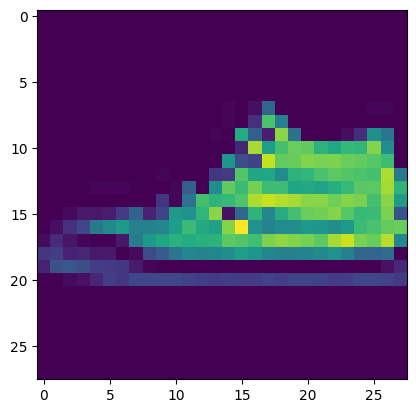

In [62]:
plt.imshow(aim[31])

## 4. Learning